# Pitch Predictor - Deep Learning Project

Owners: Jason Vasquez & Dylan Skinner

Last Modified: 9/28/2023

CS 674 Advanced Deep Learning Project 1

Dr Wingate, 2023 Fall Semester, BYU

## Introduction

The goal of this project is to use a Deep Learning Neural Network to predict a pitch in an MLB Baseball game based on circumstances that would be known to the batter before the pitch (who's pitching, number of pitches, number of outs, etc.)

Data for this project was downloaded from kaggle, courtesy of Paul Schale (https://www.kaggle.com/datasets/pschale/mlb-pitch-data-20152018). The dataset contains all pitch data from the 2015-2019 MLB Seasons, over 3 million pitches.

We begin with setting up several baselines with which we can compare the accuracy of our neural network. Our first baseline is a random pull from the distribution of pitches for the specific pitcher. The second baseline is a shallow machine learning catboost model.

In [4]:
#necessary imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import json
import os
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder

## Data Setup

##### Helper Functions

In [12]:
def read_data(file_path):

    #set the working directory
    os.chdir(file_path)
    
    # Read in data
    pitches = pd.read_csv('pitches.csv')
    names = pd.read_csv('player_names.csv')
    at_bat = pd.read_csv('atbats.csv')
    games = pd.read_csv('games.csv')

    # Read in more recent data.
    pitches_2019 = pd.read_csv('2019_pitches.csv')
    atbats_2019 = pd.read_csv('2019_atbats.csv')
    games_2019 = pd.read_csv('2019_games.csv')

    # Drop necessary columns to be able to stack data.
    games.drop(columns=['delay'], inplace=True)

    # Stack dataframes together.
    print(f'pitches.shape {pitches.shape}, at_bat.shape {at_bat.shape}, games.shape {games.shape}')
    pitches = pd.concat([pitches, pitches_2019], ignore_index=True, axis=0)
    at_bat = pd.concat([at_bat, atbats_2019], ignore_index=True, axis=0)
    games = pd.concat([games, games_2019], ignore_index=True, axis=0)
    print(f'pitches.shape {pitches.shape}, at_bat.shape {at_bat.shape}, games.shape {games.shape}')

    # Create column in names with full name.
    names['full_name'] = names['first_name'] + ' ' + names['last_name']

    return pitches, at_bat, games, names

In [9]:
def merge(pitches, at_bat, names):
    # Merge pitches and at_bats together.
    pitches_merge = pitches.merge(at_bat, on='ab_id', validate='m:1')

    # Merge pitches_merge and names together
    pitches_merge = pitches_merge.merge(names, left_on='pitcher_id', right_on='id')
    pitches_merge.drop(['last_name', 'first_name', 'id'], axis=1, inplace=True)
    pitches_merge.set_index('pitcher_id', inplace=True)

    return pitches_merge

In [11]:
def save_data(pitches_merge, file_path):
    # several columns have value 'placeholder' for many rows. Convert those all to 0.
    pitches_merge['spin_rate'] = pitches_merge.spin_rate.replace('placeholder', 0)
    pitches_merge['spin_dir'] = pitches_merge.spin_dir.replace('placeholder', 0)
    pitches_merge['type_confidence'] = pitches_merge.type_confidence.replace('placeholder', 0)
    pitches_merge['zone'] = pitches_merge.zone.replace('placeholder', 0)
    pitches_merge['x'] = pd.to_numeric(pitches_merge['x'], errors='coerce')
    pitches_merge['y'] = pd.to_numeric(pitches_merge['y'], errors='coerce')
    pitches_merge['code'] = pitches_merge.code.astype(str)
    pitches_merge['type'] = pitches_merge.type.astype(str)
    pitches_merge['top'] = pitches_merge.top.replace({1.0: True, 0.0: False})

    # Convert to parquet.
    pitches_merge.to_parquet(file_path + 'pitches_data.parquet')

##### Read in the Data from downloaded csv files

In [13]:
#change file path to wherever csv data is located
pitches, at_bats, games, names = read_data('/Users/jasonvasquez/Desktop/cs_674/PitchPredictor/csv_data')

pitches.shape (2867154, 40), at_bat.shape (740389, 11), games.shape (9718, 16)
pitches.shape (3595944, 40), at_bat.shape (925634, 11), games.shape (12126, 16)


##### Merge the pitch data with the at bat data to produce one dataset

In [14]:
pitches_merge = merge(pitches, at_bats, names)

##### Save the data as a parquet file for easy reloading

In [15]:
#change filepath for where you want to save data file
save_data(pitches_merge, file_path='/Users/jasonvasquez/Desktop/cs_674/PitchPredictor/')

##### Read in the parquet file once already saved

In [18]:
pitches_merge = pd.read_parquet('/Users/jasonvasquez/Desktop/cs_674/PitchPredictor/pitches_data.parquet')

## Pitch Distributions

Create a JSON file that contains each pitcher in the dataset and their distribution of pitchers. This will be useful for our random baseline and also will be used as a feature in our deep learning model.

##### Helper Function

In [1]:
def make_json(file_path):

    # Get all possible unique pitchers
    all_pitchers = pitches_merge.full_name.unique().tolist()

    # Create variables
    pitch_distributions = dict()

    # Iterate through all unique pitchers, getting their distribution of pitches (set up like json). Will look like this:
    # {'name': 
    #         {'pitch_keys': [keys corresponding to pitches],
    #          'pitch_dist' : [distribution of pitches (same order as keys)]}
    # }
    # Iterate through all pitchers
    for pitch in all_pitchers:
        # Get a pitcher subset
        subset = pitches_merge.loc[pitches_merge.full_name == pitch]

        # Get the distribution
        dist = subset['pitch_type'].value_counts() / np.sum(subset['pitch_type'].value_counts())

        # Create the inner dictionary (pitch_keys and pitch_dist) and add it to main dictionary with the key as the pitchers name.
        pitch_distributions[pitch] = {'pitch_keys': dist.index.tolist(), 'pitch_dist' : dist.values.tolist()}

    # j = json.load([pitch_distributions])
    j = json.dumps(pitch_distributions, indent=4)[:403]

    with open(file_path + "pitcher_distribution.json", "w") as outfile:
        json.dump(pitch_distributions, outfile)
    
    return pitch_distributions

##### Get Distribtutions and save it as a Json File for future use

In [5]:
pitch_distributions = make_json('/Users/jasonvasquez/Desktop/cs_674/PitchPredictor/')

##### Visualize Pitch Distributions and Samples from Distribution

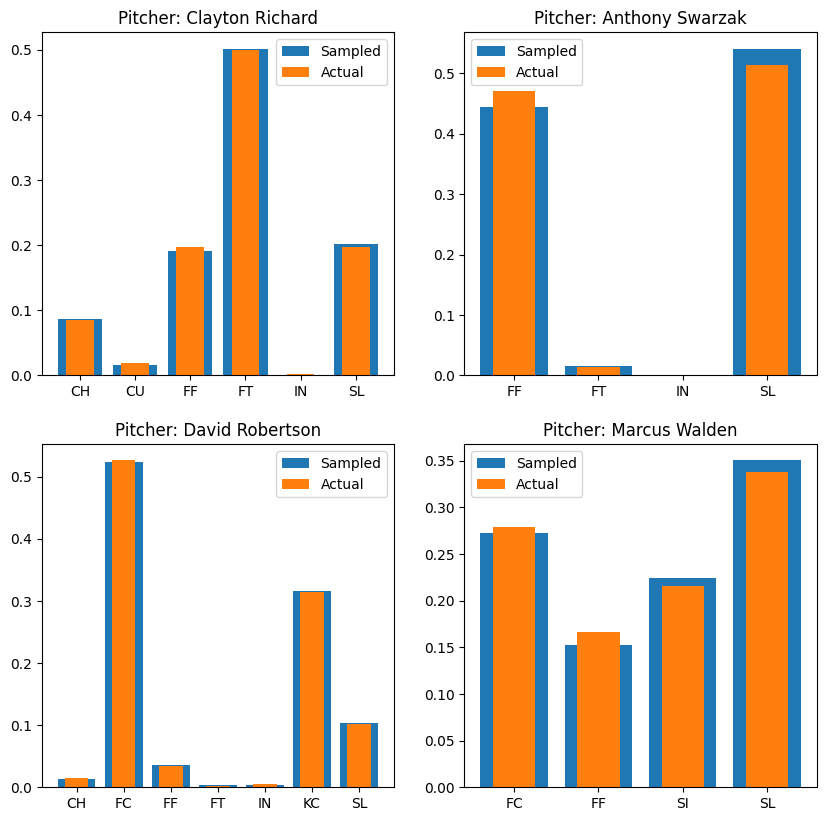

In [8]:
list_of_pitchers = list(pitch_distributions.keys())

# Initilize subplots for better viewing.
rows, cols = 2, 2
fig, ax = plt.subplots(rows, cols, figsize=(10,10), dpi=100)
r, c = 0, 0
for i in range(rows*cols):
    # Randomly select a pitcher
    randomly_selected_pitcher = np.random.choice(list_of_pitchers)

    # Get that pitchers distribution.
    randomly_selected_pitch = np.random.choice(pitch_distributions[randomly_selected_pitcher]['pitch_keys'], 
                                            p=pitch_distributions[randomly_selected_pitcher]['pitch_dist'],
                                            size=2500)

    # To ensure that things are working the way they are supposed to, randomly sample pitch types a ton and make sure the law
    # of large numbers kicks in.
    vals, counts = np.unique(randomly_selected_pitch, return_counts=True)
    ax[r, c].bar(vals, counts/np.sum(counts), label='Sampled')
    ax[r, c].bar(pitch_distributions[randomly_selected_pitcher]['pitch_keys'],
            pitch_distributions[randomly_selected_pitcher]['pitch_dist'],
            width=0.5, label='Actual')
    ax[r,c].legend()
    ax[r,c].set_title(f'Pitcher: {randomly_selected_pitcher}')

    c += 1
    if c == cols:
        r += 1
        c = 0

plt.show()

## Random Sample Baseline

##### Helper Function

In [10]:
def random_model(df_path, dist_path):
    #load in the data file
    pitches_merge = pd.read_parquet(df_path)

    #load in the json file
    with open(dist_path) as file:
        pitch_distribution = json.load(file)

    #turn json file into pandas dataframe
    pitch_distribution = pd.read_json('pitcher_distribution.json', orient='index')

    columns_to_keep = ['full_name', 'pitch_type']
    random_df = pitches_merge[columns_to_keep]

    #merge the pitch keys and distrubtion with the name
    random_df = pd.merge(random_df, pitch_distribution, left_on='full_name', right_index=True)
    random_df = random_df.dropna()

    #random model
    pitches = random_df['pitch_keys'].to_numpy()
    dists = random_df['pitch_dist'].to_numpy()
    prediction = []
    for i in range(len(pitches)):
        prediction.append(np.random.choice(pitches[i], p=dists[i], size=1)[0])

    random_df['predictions'] = prediction

    random_df['correct'] = (random_df['pitch_type'] == random_df['predictions']) * 1

    return random_df, random_df['correct'].mean()


##### Go through every pitch, and predict the pitch by randomly sampling the pitchers pitch distribution, return the dataframe with the predicted pitches and the average accuracy

In [11]:
random_df, random_acc = random_model(
      df_path = '/Users/jasonvasquez/Desktop/cs_674/PitchPredictor/pitches_data.parquet'
    , dist_path = '/Users/jasonvasquez/Desktop/cs_674/PitchPredictor/pitcher_distribution.json'
)

In [12]:
print(f"The random model predicted pitches with {round(random_acc * 100, 2)}% accuracy")

The random model predicted pitches with 32.9% accuracy


## Catboost Baseline (Dylan this is on you)

## Dataset and Dataloader

The following dataset class and dataloader will format the data to be passed in sequentially to the RNN and other similar networks

In [21]:
pitches = pd.read_parquet('/Users/jasonvasquez/Desktop/cs_674/PitchPredictor/pitches_data.parquet')

In [45]:
future_columns = ['px', 'pz', 'start_speed', 'end_speed', 'spin_rate', 'spin_dir', 
                      'break_angle', 'break_length', 'break_y', 'ax', 'ay', 'az', 'type_confidence',
                      'vx0', 'vy0', 'vz0', 'x', 'x0', 'y', 'y0', 'z0', 'pfx_x', 'pfx_z', 'nasty',
                      'zone', 'sz_bot', 'sz_top', 'event_num']

In [46]:
new_pitches = pitches.drop(columns=future_columns)

In [54]:
#fill NaN values
new_pitches['code'].replace('nan', 'B', inplace=True)

In [55]:
for col in new_pitches.columns:
    print(col)

code
type
pitch_type
b_score
ab_id
b_count
s_count
outs
pitch_num
on_1b
on_2b
on_3b
batter_id
event
g_id
inning
o
p_score
p_throws
stand
top
full_name


In [82]:
#label encode the string columns
categorical_columns = pitches.select_dtypes(include=['object'])

label_encoders = {}
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    new_pitches[column] = label_encoders[column].fit_transform(new_pitches[column])

In [84]:
new_pitches.head(5)

,code,type,pitch_type,b_score,ab_id,b_count,s_count,outs,pitch_num,on_1b,...,batter_id,event,g_id,inning,o,p_score,p_throws,stand,top,full_name
pitcher_id,,,,,,,,,,,,,,,,,,,,,
452657,2,11,6,0.0,2.015000e+09,0.0,0.0,0.0,1.0,0.0,...,572761,18,201500001.0,1.0,1,0.0,0,0,True,711
452657,14,11,6,0.0,2.015000e+09,0.0,1.0,0.0,2.0,0.0,...,572761,18,201500001.0,1.0,1,0.0,0,0,True,711
452657,5,11,6,0.0,2.015000e+09,0.0,2.0,0.0,3.0,0.0,...,572761,18,201500001.0,1.0,1,0.0,0,0,True,711
452657,1,1,6,0.0,2.015000e+09,0.0,2.0,0.0,4.0,0.0,...,572761,18,201500001.0,1.0,1,0.0,0,0,True,711
452657,1,1,2,0.0,2.015000e+09,1.0,2.0,0.0,5.0,0.0,...,572761,18,201500001.0,1.0,1,0.0,0,0,True,711


In [ ]:
def PitchDataset(Dataset):
    def __init__(self, pitches, types, transform=None):
        self.pitches = pitches
        self.types = types
        self.transform = transform


## Deep Learning Neural Network